<a href="https://colab.research.google.com/github/AranyaAryaman/Portfolio-Optimization/blob/main/Minmax_DRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries (if needed)
!pip install yfinance pandas numpy scikit-learn scipy matplotlib requests

# Import libraries
import random
import pandas as pd
import yfinance as yf
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.covariance import MinCovDet
import scipy.stats as stats
import requests
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Fetch S&P 500 companies from Wikipedia
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
headers = {"User-Agent": "Mozilla/5.0"}

response = requests.get(url, headers=headers)
tables = pd.read_html(response.text)

df = tables[0]
tickers = df['Symbol'].tolist()
print(tickers)
# Randomly sample 50 tickers
random.seed(42)  # For reproducibility
sampled_tickers = random.sample(tickers, 50)
print(f"Sampled {len(sampled_tickers)} tickers")

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'AON', 'APA', 'APO', 'AAPL', 'AMAT', 'APP', 'APTV', 'ACGL', 'ADM', 'ARES', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BAX', 'BDX', 'BRK.B', 'BBY', 'TECH', 'BIIB', 'BLK', 'BX', 'XYZ', 'BK', 'BA', 'BKNG', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'BXP', 'CHRW', 'CDNS', 'CPT', 'CPB', 'COF', 'CAH', 'CCL', 'CARR', 'CAT', 'CBOE', 'CBRE', 'CDW', 'COR', 'CNC', 'CNP', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'COIN', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CRWD', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', 'DRI', 'DDOG', 

In [7]:
# Define date range
START = dt.date.today() - dt.timedelta(days=5*365)
END = dt.date.today()

# Download data with error handling
print("Downloading stock data...")
data = yf.download(sampled_tickers, start=START, end=END, progress=True)

# Check if data is empty
if data.empty:
    print("No data downloaded. Please check your tickers.")
else:
    print(f"Downloaded data shape: {data.shape}")

# Display structure
print(f"\nColumn structure: {type(data.columns)}")
print(f"Column levels: {data.columns.nlevels if hasattr(data.columns, 'nlevels') else 'Single level'}")

[                       0%                       ]

[*********************100%***********************]  50 of 50 completed

Downloaded data shape: (1256, 250)

Column structure: <class 'pandas.core.indexes.multi.MultiIndex'>
Column levels: 2


In [8]:
# Handle MultiIndex columns from multi-ticker download
if isinstance(data.columns, pd.MultiIndex):
    # Extract Adj Close prices
    if 'Adj Close' in data.columns.get_level_values(0):
        adj_close = data['Adj Close']
    else:
        # Fallback to Close if Adj Close not available
        adj_close = data['Close']

    # Drop columns with all NaN values
    adj_close = adj_close.dropna(axis=1, how='all')
    valid_tickers = adj_close.columns.tolist()
else:
    # Single ticker case
    adj_close = data[['Adj Close']] if 'Adj Close' in data.columns else data[['Close']]
    valid_tickers = [sampled_tickers[0]]

# Calculate returns
returns = adj_close.pct_change().dropna()

print(f"Valid tickers ({len(valid_tickers)}): {valid_tickers[:10]}...")  # Show first 10
print(f"Returns shape: {returns.shape}")
print(f"Date range: {returns.index[0]} to {returns.index[-1]}")

Valid tickers (50): ['ABBV', 'AIZ', 'AKAM', 'ALB', 'ALGN', 'ALLE', 'ARES', 'ATO', 'AZO', 'BALL']...
Returns shape: (1173, 50)
Date range: 2021-04-15 00:00:00 to 2025-12-12 00:00:00


In [9]:
# Split into training (80%) and testing (20%) sets
split_index = int(0.8 * len(returns))
train_returns = returns[:split_index]
test_returns = returns[split_index:]

print(f"Training period: {train_returns.index[0]} to {train_returns.index[-1]} ({len(train_returns)} days)")
print(f"Testing period: {test_returns.index[0]} to {test_returns.index[-1]} ({len(test_returns)} days)")

Training period: 2021-04-15 00:00:00 to 2025-01-06 00:00:00 (938 days)
Testing period: 2025-01-07 00:00:00 to 2025-12-12 00:00:00 (235 days)


In [10]:
def get_mean_variance_weights(returns, shrinkage=1e-4):
    """Calculate optimal portfolio weights using mean-variance optimization"""
    def portfolio_volatility(weights, mean_returns, cov_matrix):
        return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    returns_imputed = imputer.fit_transform(returns)

    # Calculate trimmed mean
    trim_percentage = 0.02
    trimmed_mean_returns = np.apply_along_axis(
        lambda x: stats.trim_mean(x, trim_percentage), 0, returns_imputed
    )

    # Calculate robust covariance matrix
    robust_cov_estimator = MinCovDet().fit(returns_imputed)
    cov_matrix = robust_cov_estimator.covariance_

    # Add shrinkage if matrix is not full rank
    rank = np.linalg.matrix_rank(cov_matrix)
    if rank < cov_matrix.shape[0]:
        cov_matrix += np.eye(cov_matrix.shape[0]) * shrinkage

    num_assets = len(trimmed_mean_returns)
    args = (trimmed_mean_returns, cov_matrix)

    # Optimization constraints and bounds
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_weights = np.array([1.0 / num_assets] * num_assets)

    result = minimize(portfolio_volatility, initial_weights, args=args,
                     method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

print("Mean-Variance Optimization function defined")

Mean-Variance Optimization function defined


In [11]:
def gmm_sentiment_1(stock_returns, date, window_size=10):
    """
    Predict sentiment using GMM on rolling average returns for individual stocks
    """
    # Calculate 5-day rolling average
    rolling_avg_returns = stock_returns.rolling(5).mean().loc[:date].tail(window_size)

    # Filter out NaNs
    valid_data = rolling_avg_returns.dropna().values.reshape(-1, 1)
    n_samples = len(valid_data)

    if n_samples >= 2:
        n_components = min(3, n_samples)
        gmm = GaussianMixture(n_components=n_components, random_state=42).fit(valid_data)
        sentiment_label = gmm.predict(valid_data[-1].reshape(1, -1))[0]

        # Map sentiment to strategy
        if sentiment_label == 0:
            return "Long"
        elif sentiment_label == 1:
            return "Neutral"
        else:
            return "Short"
    else:
        return "Neutral"

# Apply GMM sentiment analysis to each stock
window_size = 10
strategy_data = {}

print("Analyzing stock-level sentiment...")
for stock in train_returns.columns:
    strategy_data[stock] = []
    for date in train_returns.index[window_size:]:
        strategy = gmm_sentiment_1(train_returns[stock], date, window_size)
        strategy_data[stock].append((date, strategy))

# Convert to DataFrame
strategy_df = {}
for stock, strategies in strategy_data.items():
    strategy_df[stock] = pd.DataFrame(strategies, columns=["Date", "Strategy"]).set_index("Date")

print("Stock-level sentiment analysis complete")

Analyzing stock-level sentiment...
Stock-level sentiment analysis complete


In [12]:
# Collect stocks labeled 'Long' at end of training period
long_stocks_1 = []
last_train_date = train_returns.index[-1]

for stock in train_returns.columns:
    strategy = gmm_sentiment_1(train_returns[stock], last_train_date, window_size)
    if strategy == "Long":
        long_stocks_1.append(stock)

print(f"Stocks labeled 'Long' (stock-level GMM): {len(long_stocks_1)}")
print(long_stocks_1)

Stocks labeled 'Long' (stock-level GMM): 15
['ALB', 'ALGN', 'AZO', 'CDNS', 'COIN', 'CPAY', 'DELL', 'FITB', 'O', 'ORLY', 'PLD', 'RJF', 'SJM', 'SPG', 'USB']


In [13]:
# Fit GMM on entire market behavior
print("Fitting market-level GMM...")
gmm_sentiment_2 = GaussianMixture(n_components=3, random_state=42)
gmm_sentiment_2.fit(train_returns)

# Predict sentiment regime
train_sentiment_labels = gmm_sentiment_2.predict(train_returns)
train_sentiments = pd.Series(train_sentiment_labels, index=train_returns.index)

# Map sentiments to strategies
market_strategy = train_sentiments.map({0: 'neutral', 1: 'long', 2: 'short'})

print("Market-level sentiment mapping complete")
print(f"Sentiment distribution:\n{market_strategy.value_counts()}")

Fitting market-level GMM...
Market-level sentiment mapping complete
Sentiment distribution:
short      693
neutral    127
long       118
Name: count, dtype: int64


In [17]:
def assign_strategy(market_strategy_series, num_stocks, columns):
    """Assign strategies to stocks based on market sentiment"""
    strategies = []
    for sentiment in market_strategy_series.values:
        if sentiment == 1:  # long
            strategies.append(['long'] * num_stocks)
        else:
            strategies.append(np.random.choice(['long', 'short', 'neutral'], size=num_stocks))
    return pd.DataFrame(strategies, columns=columns, index=market_strategy_series.index)

# Assign strategies - pass the full Series with index, not just values
strategy_stock_map = assign_strategy(train_sentiments, len(train_returns.columns), train_returns.columns)

# Collect 'Long' stocks at end of training period
last_train_day = strategy_stock_map.index[-1]
long_stocks_2 = strategy_stock_map.loc[last_train_day][
    strategy_stock_map.loc[last_train_day] == 'long'
].index.tolist()

print(f"Long stocks (market-level GMM): {len(long_stocks_2)}")
print(long_stocks_2[:10])  # Show first 10

Long stocks (market-level GMM): 50
['ABBV', 'AIZ', 'AKAM', 'ALB', 'ALGN', 'ALLE', 'ARES', 'ATO', 'AZO', 'BALL']


In [18]:
def L_infinity_norm(returns, weights):
    """Calculate L-infinity norm (max deviation from mean)"""
    portfolio_returns = np.dot(returns, weights)
    return np.max(np.abs(portfolio_returns - np.mean(portfolio_returns)))

def minimax_model_1(returns, initial_weights=None):
    """
    Minimax model using L-infinity as risk measure
    Minimizes maximum deviation from mean return
    """
    num_stocks = returns.shape[1]

    if num_stocks == 0:
        raise ValueError("Number of stocks must be greater than zero")

    if initial_weights is None:
        initial_weights = np.array([1.0 / num_stocks] * num_stocks)

    bounds = [(0, 1)] * num_stocks
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

    def objective_max(weights):
        return L_infinity_norm(returns.values, weights)

    result = minimize(objective_max, initial_weights, method='SLSQP',
                     bounds=bounds, constraints=constraints)
    return result.x

print("Minimax Model 1 defined")

Minimax Model 1 defined


In [19]:
def minimax_model_2(returns, G, upper_bounds):
    """
    Minimax model that maximizes minimum portfolio return
    subject to return constraint G
    """
    n_assets = returns.shape[1]

    def objective(x):
        portfolio_returns = np.dot(returns, x)
        Mp = np.min(portfolio_returns)
        return -Mp  # Maximize Mp by minimizing -Mp

    def weight_sum_constraint(x):
        return np.sum(x) - 1

    def min_required_return_constraint(x):
        portfolio_returns = np.dot(returns, x)
        return np.min(portfolio_returns) - G

    x0 = np.array([1/n_assets] * n_assets)
    bounds = [(0, u) for u in upper_bounds]

    constraints_list = [
        {'type': 'eq', 'fun': weight_sum_constraint},
        {'type': 'ineq', 'fun': min_required_return_constraint}
    ]

    options = {'ftol': 1e-9, 'maxiter': 1000}
    result = minimize(objective, x0, bounds=bounds, constraints=constraints_list,
                     method='SLSQP', options=options)
    return result

def generate_random_upper_bounds(n_assets):
    """Generate random upper bounds that sum to <= 1"""
    random_bounds = np.random.rand(n_assets)
    normalized_bounds = random_bounds / np.sum(random_bounds)
    return normalized_bounds.tolist()

print("Minimax Model 2 defined")

Minimax Model 2 defined


In [20]:
# Filter returns for long stocks only
if len(long_stocks_1) > 0:
    train_returns_long_1 = train_returns[long_stocks_1]
    test_returns_long_1 = test_returns[long_stocks_1]
    print(f"Stock-level GMM: {len(long_stocks_1)} long stocks")
else:
    print("Warning: No long stocks from stock-level GMM. Using all stocks.")
    train_returns_long_1 = train_returns
    test_returns_long_1 = test_returns

if len(long_stocks_2) > 0:
    train_returns_long_2 = train_returns[long_stocks_2]
    test_returns_long_2 = test_returns[long_stocks_2]
    print(f"Market-level GMM: {len(long_stocks_2)} long stocks")
else:
    print("Warning: No long stocks from market-level GMM. Using all stocks.")
    train_returns_long_2 = train_returns
    test_returns_long_2 = test_returns

Stock-level GMM: 15 long stocks
Market-level GMM: 50 long stocks


In [21]:
# Parameters
G = 0.009  # Required return threshold

print("Calculating portfolio weights...")

# Minimax Model 1 weights
test_weights_1 = minimax_model_1(test_returns_long_1)
test_weights_2 = minimax_model_1(test_returns_long_2)

# Minimax Model 2 weights
test_weights_12 = minimax_model_2(
    test_returns_long_1, G,
    generate_random_upper_bounds(test_returns_long_1.shape[1])
)
test_weights_22 = minimax_model_2(
    test_returns_long_2, G,
    generate_random_upper_bounds(test_returns_long_2.shape[1])
)

# Mean-Variance Optimization weights
mvo_weights = get_mean_variance_weights(test_returns, shrinkage=1e-4)

print("All portfolio weights calculated successfully")

Calculating portfolio weights...
All portfolio weights calculated successfully


In [22]:
# Calculate portfolio returns for each strategy
test_portfolio_returns_1 = np.dot(test_returns_long_1, test_weights_1)
test_portfolio_returns_2 = np.dot(test_returns_long_2, test_weights_2)
test_portfolio_returns_12 = np.dot(test_returns_long_1, test_weights_12.x)
test_portfolio_returns_22 = np.dot(test_returns_long_2, test_weights_22.x)
mvo_portfolio_returns = np.dot(test_returns, mvo_weights)

print("Portfolio returns calculated")

# Show summary statistics
print(f"\nMinimax 1 (stock GMM) mean return: {test_portfolio_returns_1.mean():.4f}")
print(f"Minimax 1 (market GMM) mean return: {test_portfolio_returns_2.mean():.4f}")
print(f"Minimax 2 (stock GMM) mean return: {test_portfolio_returns_12.mean():.4f}")
print(f"Minimax 2 (market GMM) mean return: {test_portfolio_returns_22.mean():.4f}")
print(f"MVO mean return: {mvo_portfolio_returns.mean():.4f}")

Portfolio returns calculated

Minimax 1 (stock GMM) mean return: 0.0004
Minimax 1 (market GMM) mean return: 0.0003
Minimax 2 (stock GMM) mean return: 0.0004
Minimax 2 (market GMM) mean return: 0.0003
MVO mean return: 0.0009


In [24]:
def calculate_cumulative(returns):
    """Calculate cumulative returns and return as pandas Series"""
    if isinstance(returns, np.ndarray):
        # Convert numpy array to pandas Series with proper index
        cumulative_returns = (1 + pd.Series(returns)).cumprod() - 1
    else:
        # Already a pandas Series or DataFrame
        cumulative_returns = (1 + returns).cumprod() - 1
    return cumulative_returns

# Calculate cumulative returns for all strategies
cumulative_test_returns_1 = calculate_cumulative(test_portfolio_returns_1)
cumulative_test_returns_2 = calculate_cumulative(test_portfolio_returns_2)
cumulative_test_returns_12 = calculate_cumulative(test_portfolio_returns_12)
cumulative_test_returns_22 = calculate_cumulative(test_portfolio_returns_22)
cumulative_mvo_returns = calculate_cumulative(mvo_portfolio_returns)

print("Cumulative returns calculated")
print(f"\nFinal cumulative returns:")
print(f"Minimax 1 (stock GMM): {cumulative_test_returns_1.iloc[-1]:.2%}")
print(f"Minimax 1 (market GMM): {cumulative_test_returns_2.iloc[-1]:.2%}")
print(f"Minimax 2 (stock GMM): {cumulative_test_returns_12.iloc[-1]:.2%}")
print(f"Minimax 2 (market GMM): {cumulative_test_returns_22.iloc[-1]:.2%}")
print(f"MVO: {cumulative_mvo_returns.iloc[-1]:.2%}")

Cumulative returns calculated

Final cumulative returns:
Minimax 1 (stock GMM): 8.92%
Minimax 1 (market GMM): 6.04%
Minimax 2 (stock GMM): 9.41%
Minimax 2 (market GMM): 7.19%
MVO: 22.26%


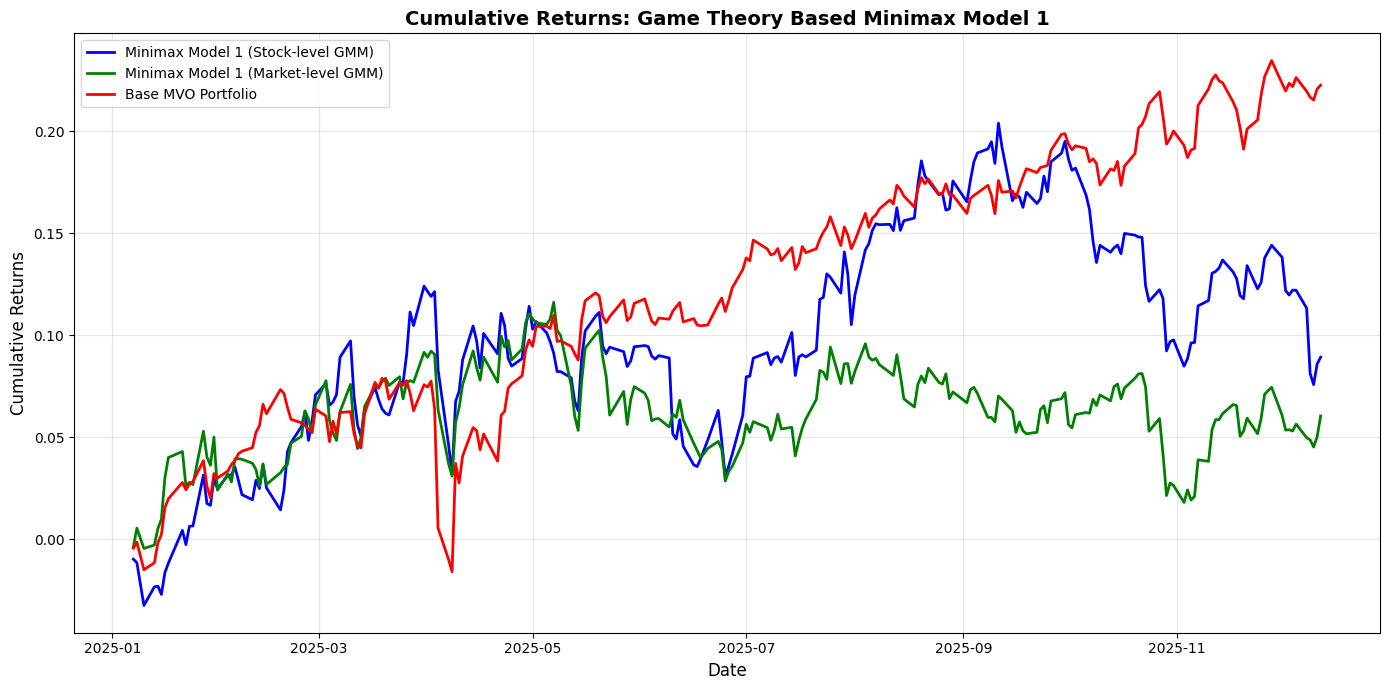

In [25]:
plt.figure(figsize=(14, 7))
plt.plot(test_returns_long_1.index, cumulative_test_returns_1,
         label='Minimax Model 1 (Stock-level GMM)', color='blue', linewidth=2)
plt.plot(test_returns_long_2.index, cumulative_test_returns_2,
         label='Minimax Model 1 (Market-level GMM)', color='green', linewidth=2)
plt.plot(test_returns.index, cumulative_mvo_returns,
         label='Base MVO Portfolio', color='red', linewidth=2)

plt.title('Cumulative Returns: Game Theory Based Minimax Model 1', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

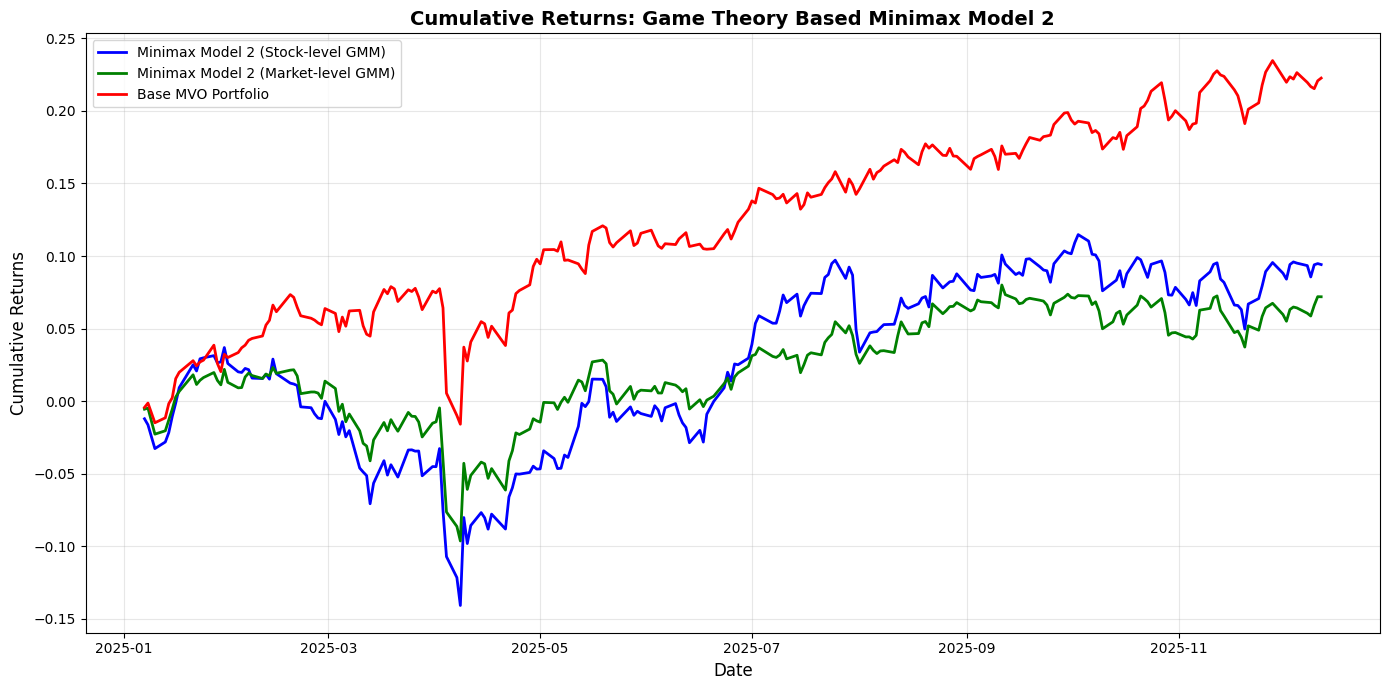

In [26]:
plt.figure(figsize=(14, 7))
plt.plot(test_returns_long_1.index, cumulative_test_returns_12,
         label='Minimax Model 2 (Stock-level GMM)', color='blue', linewidth=2)
plt.plot(test_returns_long_2.index, cumulative_test_returns_22,
         label='Minimax Model 2 (Market-level GMM)', color='green', linewidth=2)
plt.plot(test_returns.index, cumulative_mvo_returns,
         label='Base MVO Portfolio', color='red', linewidth=2)

plt.title('Cumulative Returns: Game Theory Based Minimax Model 2', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()